In [1]:
# Calibrate camera based on the checkerboard pattern data


In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


In [3]:
#Set the variables
folderpath = "calibrate_camera_images"
width = 9 # Width of checkerboard
height = 6 # Height of checkerboard pattern
square_size = 0.05 # Length of edge of square in meters
flag_show_checkerboard_images = False

Reading images from folder: calibrate_camera_images
Processing Image:  calibrate_camera_images\left01.jpg
Initial corners found


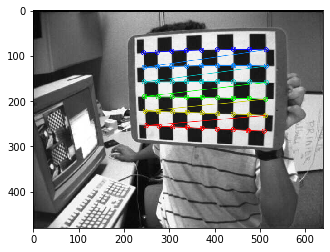

Processing Image:  calibrate_camera_images\left02.jpg
Initial corners found


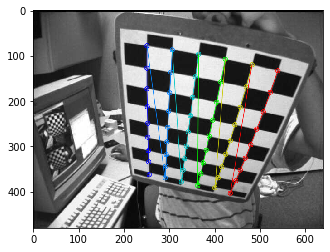

Processing Image:  calibrate_camera_images\left03.jpg
Initial corners found


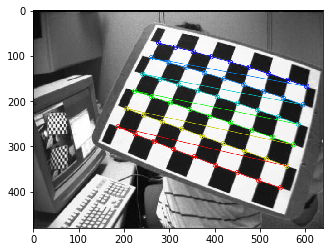

Processing Image:  calibrate_camera_images\left04.jpg
Initial corners found


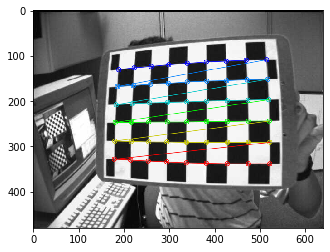

Processing Image:  calibrate_camera_images\left05.jpg
Initial corners found


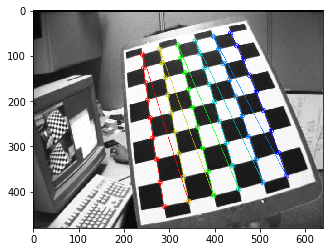

Processing Image:  calibrate_camera_images\left06.jpg
Initial corners found


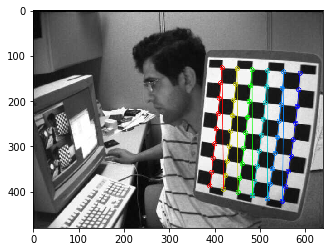

Processing Image:  calibrate_camera_images\left07.jpg
Initial corners found


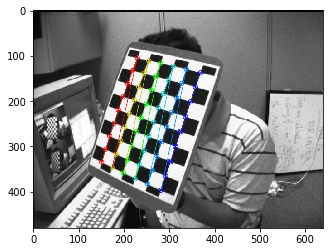

Processing Image:  calibrate_camera_images\left08.jpg
Initial corners found


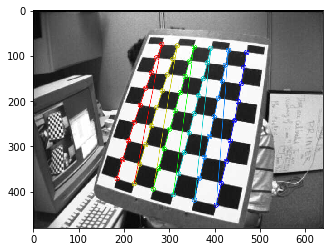

Processing Image:  calibrate_camera_images\left09.jpg
Initial corners found


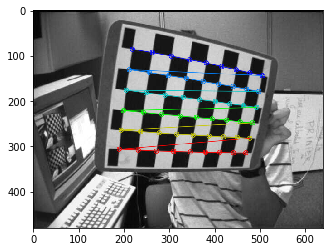

Processing Image:  calibrate_camera_images\left11.jpg
Initial corners found


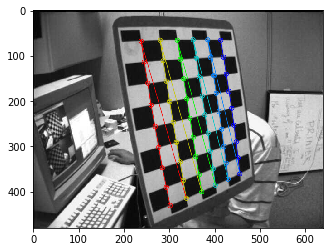

Processing Image:  calibrate_camera_images\left12.jpg
Initial corners found


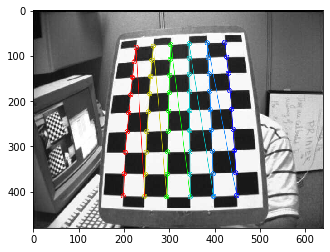

Processing Image:  calibrate_camera_images\left13.jpg
Initial corners found


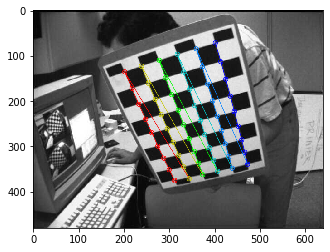

Processing Image:  calibrate_camera_images\left14.jpg
Initial corners found


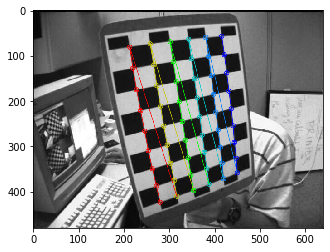

Calculating the Reprojection Error
Reprojection Error for image 0/13 = 0.026px
Reprojection Error for image 1/13 = 0.166px
Reprojection Error for image 2/13 = 0.024px
Reprojection Error for image 3/13 = 0.026px
Reprojection Error for image 4/13 = 0.022px
Reprojection Error for image 5/13 = 0.025px
Reprojection Error for image 6/13 = 0.032px
Reprojection Error for image 7/13 = 0.033px
Reprojection Error for image 8/13 = 0.041px
Reprojection Error for image 9/13 = 0.023px
Reprojection Error for image 10/13 = 0.027px
Reprojection Error for image 11/13 = 0.063px
Reprojection Error for image 12/13 = 0.024px
Mean Error for the dataset is: 0.04090467898119255px
Reprojection error below 1 px is generally considered a good result.


In [4]:
# Calibrate camera function
def calibrate_camera(folderpath, square_size, width=9, height=6, flag_show_checkerboard_images=False):
    
    
    # Make the object points in World. Z=0 for the object plane
    # Example object points (0,0,0), (1,0,0) (2,0,0) ... (7,5,0), (8,5,0)
    
    objpts = np.zeros((height*width,3), np.float32)
    
    #Create the grid for X aand Y points
#     objpts[:,:2] = np.mgrid[0:width, 0:height].T.reshape(-1,2)
    xx,yy = np.meshgrid(np.arange(0,width,1), np.arange(0,height,1))
    
    # Reshape into 1d array
    xx = xx.reshape(-1)
    yy = yy.reshape(-1)
    
    # Update coordinates of the XY points 
    objpts[:,0] = xx
    objpts[:,1] = yy    

    # Sacle by the true size
    objpts = square_size* objpts
    
#     print(objpts)
    
    # Create the arrays to store the object points and image points for all images
    objPointsArray = []
    imagePointsArray = []
    
    
    # Termination criteria for stopping subpixel corner calculation
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)

    
    #Get all the images
    images = os.listdir(folderpath)
    
    print("Reading images from folder: " + folderpath)
    
    for fname in images:
        current_fname = os.path.join(folderpath,fname)
        print("Processing Image: ", current_fname)
        img = cv2.imread(current_fname) # Read as grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
                
        #Find the chessboard corners
        ret,corners = cv2.findChessboardCorners(gray,(width,height),
                                               cv2.CALIB_CB_ADAPTIVE_THRESH 
                                                + cv2.CALIB_CB_FAST_CHECK 
                                                + cv2.CALIB_CB_NORMALIZE_IMAGE)
        
        #If the corners are detected, run subpixel accuracy
        if ret:
            
            print("Initial corners found")
            
            #Append the object points
            objPointsArray.append(objpts)
            corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
            
            # Append the image pts
            imagePointsArray.append(corners2)
            
            # Draw the corners
            img = cv2.drawChessboardCorners(img,(width,height),corners2,ret)
            

            if(flag_show_checkerboard_images):
                plt.imshow(img, cmap='gray')
                plt.show()
        
        else:
            print("Error detecting corners in this image ")
        
    # Once all the calibration files have been processed, run the calibrate camera using Zhang's method on this data
    retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objPointsArray,imagePointsArray,img.shape[:2],None,None)
    
    # Save the values of the cameraMatrix and the distortion ccoeffs
    np.save("calibration_matrix", cameraMatrix)
    np.save("distCoeffs", distCoeffs)
    
    print("Calculating the Reprojection Error")
    # Calculate the reprojection error
    mean_error = 0
    numImageUsed = len(objPointsArray)
    for i in range(numImageUsed):
        # Project object pts to image coordinates 
        imgpts2, _ = cv2.projectPoints(objPointsArray[i],
                                       rvecs[i],tvecs[i],
                                       cameraMatrix,distCoeffs)
        
        # Calculate error in these projected points and the actual captured points
        error = cv2.norm(imagePointsArray[i] - imgpts2,cv2.NORM_L2)/len(imgpts2)
        
        print("Reprojection Error for image {}/{} = {:.3f}px".format(i,numImageUsed,error))
        
        mean_error+=error
 
    mean_error /= numImageUsed
    print("Mean Error for the dataset is: {}px".format(mean_error))
    print("Reprojection error below 1 px is generally considered a good result.")

 
        
    
    return [retval, cameraMatrix, distCoeffs, rvecs, tvecs]
    
                      
output = calibrate_camera("calibrate_camera_images",0.05, 9,6,True)    
    

In [5]:
# Print all the returned values:
[retval, cameraMatrix, distCoeffs, rvecs, tvecs] = output

print("The results of the camera calibration are:")
print("retval (opencv calculated reprojection error in px) is : {} \n ".format(retval))
print("cameraMatrix is : \n {} \n ".format(cameraMatrix))
print("distCoeffs are  : \n {} \n ".format(distCoeffs))
print("Rotation vector for the images are : \n {} \n ".format(rvecs))
print("Rotation vector for the images are : {} \n ".format(tvecs))



The results of the camera calibration are:
retval (opencv calculated reprojection error in px) is : 0.4079420579438008 
 
cameraMatrix is : [[536.06446459   0.         342.36861217]
 [  0.         536.00714135 235.53172266]
 [  0.           0.           1.        ]] 
 
distCoeffs are  : [[-0.26511852 -0.0465947   0.00183175 -0.00031504  0.25214177]] 
 
Rotation vector for the images are : [array([[0.16852557],
       [0.2757572 ],
       [0.0134676 ]]), array([[ 0.41307559],
       [ 0.64936304],
       [-1.33719522]]), array([[-0.27697678],
       [ 0.18689512],
       [ 0.35483178]]), array([[-0.11083267],
       [ 0.23974977],
       [-0.00213544]]), array([[-0.29188899],
       [ 0.42830183],
       [ 1.31269937]]), array([[0.40772952],
       [0.30385862],
       [1.64906232]]), array([[0.17947306],
       [0.34574368],
       [1.86847178]]), array([[-0.09096166],
       [ 0.47966602],
       [ 1.75338366]]), array([[ 0.2028918 ],
       [-0.4241466 ],
       [ 0.13245584]]), arra